# Grover's algorithm implementation in Rigetti Forest with 2 qubits

## Installation
To execute quantum simulations using Rigetti Forest SDK it is first required to install the pyQuil library, the Quantum Virtual Machine and the Compiler following the instructions at this link http://docs.rigetti.com/en/stable/start.html.<br>
The procedure is easy and all the components are lightweight.<br>
After the installation, start the QVM and the Compiler as described in the "Setting Up Server Mode for PyQuil" section.<br>
Now we can start working on the Grover's algorithm implementation!<br>
Let's try to implement the version for only two qubits and we want to find the element |11><br>
The Quantum Circuit is the following:<br>
<img src="img/gates_11.png" width="800"/><br>

This circuit is optimized for this specific problem instance. In the following notebook we will learn more about techniques to build circuits for every possible instance with an arbitrary number of qubits.

## Setup, wavefunction and superposition

First we import the required libraries, setup the virtual machine as a lattice of 9 qubits in total and instantiate the empty program. <br>
Usually the qubits in a real Rigetti quantum computer are placed in a lattice, but it is possible to specify different architectures in the virtual machine (e.g. <i>5q-qvm</i> is a fully connected network of qubits), but if the program is later supposed to be executed on a real quantum computer, the code will have to be changed.<br>
Is is possible to obtain a list of quantum computers names through the <a href="http://docs.rigetti.com/en/stable/apidocs/quantum_computer.html#pyquil.list_quantum_computers">list_quantum_computers()</a> function.

In [1]:
from pyquil import Program, get_qc
from pyquil.gates import *
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

qvm = get_qc('9q-square-qvm')
n_qubits = 2
qubits = list(range(n_qubits))
p = Program()

The Forest SDK has an interesting feature which is the Wavefunction Similator: it is possible to inspect the wavefunction of a quantum state prepared by the program.<br>
This feature it is obviously possible only in the Virtual Machine because in real quantum computers the wavefunction is unknown.<br>
The wavefunction corresponding to the current program is the following.

In [2]:
from pyquil.api import WavefunctionSimulator
wfs = WavefunctionSimulator()
print(wfs.wavefunction(p))

(1+0j)|0>


The wave function is corresponding to the state 0 with a probability of $1^{2}=1$ because the qubits are all set to zero.<br>
Let's now apply some operators of the Grover's algorithm.<br><br>
The gates of the first slot are the Hadamard gates used to put the two qubits into superposition.<br>

In [3]:
def superposition(p, qubits):
    for qubit in qubits:
        p += H(qubit)

Let's apply the superposition gates and print the program to see if the gates have ben added to the circuit.

In [4]:
superposition(p, qubits)
print(p)

H 0
H 1



If we inspect the wavefunction now we see that all the four possible states (|00>, |01>, |10>, |11>) are equally probable because they are in superposition, with a probability of $0.5^{2} = 0.25$ each.

In [5]:
print(wfs.wavefunction(p))

(0.5+0j)|00> + (0.5+0j)|01> + (0.5+0j)|10> + (0.5+0j)|11>


## Oracle and controlled gates

Before describing the design of the oracle a simple concept has to be introduced: the controlled gates.<br>
Controlled gates act on 2 or more qubits, where one or more qubits act as a control for some operation. For example, the controlled NOT gate (or CNOT or cX) acts on 2 qubits, and performs the NOT operation on the second qubit only when the first qubit is |1>, and otherwise leaves it unchanged.<br>
More generally if <i>U</i> is a gate that operates on single qubits with matrix representation

$$ U=
\begin{bmatrix}
u_{00}&u_{01}\\
u_{10}&u_{11}
\end{bmatrix} 
$$
The matrix representing the controlled U is

$$ C(U)=
\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&u_{00}&u_{01}\\
0&0&u_{10}&u_{11}
\end{bmatrix}
$$

Hence, the matrix representation of the CNOT gate is:
$$ CNOT=
\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&0&1\\
0&0&1&0
\end{bmatrix}
$$
The controlled modifier can have multiple qubits as control qubits (e.g. the CCNOT has two control qubits and one target).

We can now define the oracle for the element |11> we are searching for and add it to the program.<br>

In [6]:
def oracle(p, qubits):
    p += H(1)
    p += CNOT(0,1)
    p += H(1)

oracle(p, qubits)

In [7]:
print(wfs.wavefunction(p))

(0.5+0j)|00> + (0.5+0j)|01> + (0.5+0j)|10> + (-0.5+0j)|11>


The wavefunction is now similar to the previous, the only effect is the flip of the state |11>, that has now a negative amplitude.<br>
It corresponds to the effect that the oracle is to supposed to have: flip the sign only of the solution state.<br>
Let's apply the diffusion operator.

In [8]:
def phase_shift(p, qubits):
    for qubit in qubits:
        p += X(qubit)
    p += H(1)
    p += CNOT(0, 1)
    p += H(1)
    for qubit in qubits:
        p += X(qubit)

# Apply diffusion operator
superposition(p, qubits)
phase_shift(p, qubits)
superposition(p, qubits)

print(wfs.wavefunction(p))

(-1+0j)|11>


For the concepts explained in the previous notebook on the theory behind the Grover's algorithm, after only one iteration the probability of collapsing into the state |11> is already one, as shown by the wavefunction.<br>
The only things left to do now are to compile, run and measure the program.

In [9]:
#Add the measure operators
p = p.measure_all()
    
print(p)

H 0
H 1
H 1
CNOT 0 1
H 1
H 0
H 1
X 0
X 1
H 1
CNOT 0 1
H 1
X 0
X 1
H 0
H 1
DECLARE ro BIT[2]
MEASURE 0 ro[0]
MEASURE 1 ro[1]



In [10]:
def plot_result(result, n_qubits):
    result_int = result.dot(2**np.arange(n_qubits)[::-1])
    int2binary = np.vectorize(np.binary_repr)
    result_string = int2binary(result_int, n_qubits)

    counts = Counter(result_string)
    bit_strings = int2binary(np.arange(0, 2**n_qubits), n_qubits)
    counts = [counts[bit_string] for bit_string in bit_strings]
    frequencies = [value/len(result_int) for value in counts]
    

    plt.bar(bit_strings, frequencies)
    plt.show()

In [12]:
#Execute the algorithm 10 times
p.wrap_in_numshots_loop(10)

#Compile and run
grover = qvm.compile(p)
result = qvm.run(grover)
print(result)

[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]


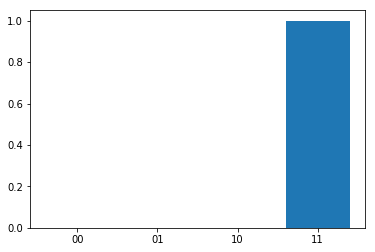

In [13]:
def plot_result(result, n_qubits):
    result_int = result.dot(2**np.arange(n_qubits)[::-1])
    int2binary = np.vectorize(np.binary_repr)
    result_string = int2binary(result_int, n_qubits)

    counts = Counter(result_string)
    bit_strings = int2binary(np.arange(0, 2**n_qubits), n_qubits)
    counts = [counts[bit_string] for bit_string in bit_strings]
    frequencies = [value/len(result_int) for value in counts]
    

    plt.bar(bit_strings, frequencies)
    plt.show()

plot_result(result, n_qubits)

As expected, all the ten program runs return |11> as a result because the probability of returning the solution is 1 in the case of two qubits circuit.<br><br>

## Controlled Z implementation
Notice that the oracle can also be implemented with the Controlled Z gate.<br>


Hence, the CZ gate has matrix representation
$$ CZ=
\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&1&0\\
0&0&0&-1
\end{bmatrix}
$$

In [14]:
def oracleZ(p, qubits):
    p += CZ(0,1)
    
def phase_shiftZ(p, qubits):
    for qubit in qubits:
        p += X(qubit)
    p += CZ(0,1)
    for qubit in qubits:
        p += X(qubit)

pZ = Program()
superposition(pZ, qubits)

oracleZ(pZ, qubits)

superposition(pZ, qubits)
phase_shiftZ(pZ, qubits)
superposition(pZ, qubits)

pZ = pZ.measure_all()
print(pZ)

pZ.wrap_in_numshots_loop(10)

grover = qvm.compile(pZ)
result = qvm.run(grover)
print(result)

H 0
H 1
CZ 0 1
H 0
H 1
X 0
X 1
CZ 0 1
X 0
X 1
H 0
H 1
DECLARE ro BIT[2]
MEASURE 0 ro[0]
MEASURE 1 ro[1]

[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]


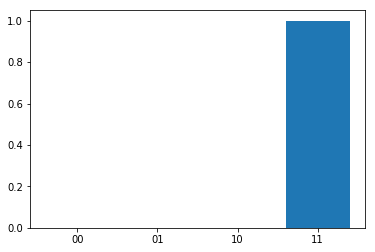

In [15]:
plot_result(result, n_qubits)

The example presented is a trivial case but it useful to start to understand how quantum computing works and to familiarize with the Rigetti Forest SDK.<br>
In the following notebooks more complex examples will be presented.